# 3D natisnjeni metamateriali za aplikacijo v dinamiki


<img src="Skica problema.png" width="200">

In [1]:
import numpy as np
import scipy.linalg as lin
import math as m
import matplotlib.pyplot as plt

In [2]:
np.set_printoptions(precision=3)
np.set_printoptions(threshold=sys.maxsize)

In [3]:
from numpy import ndarray
import scipy
import string

class BaseCell:
    def __init__(self, E:int,I:float,A:float, L:float,rho:float,n:int,k:float,m:float, BC=[1, 0]):
        """
        Creates a BaseCell object

        Creates an object of a metamaterial basecell with input parametres.
        :param E: Young module (GPa)
        :param I: Moment of inertia (mm4)
        :param A: Cross-section (mm2)
        :param L: lght (mm)
        :param rho: Density of material (kg/m3)
        :param n: Number of nodes
        :param k: Stiffness of resonator (N/m)
        :param m: Mass of resonator unit (g)
        """
        if n//2 == 0:
            raise ValueError("Number of nodes n should be odd")

        #Default units: MPa, N, mm, g
            
        self.E = E*10**3
        self.I = I
        self.L = L
        self.A = A
        self.rho = rho*10**(-6)
        self.n = n - 1 #Convert from nodes to amount of sections
        self.k = k*10**(-3)
        self.m = m

        self.DOF = 4
        self.center = 0

        #lenght of finite element
        self.l = self.L/self.n

        #BOUNDARY CONDITIONS
        self.Restricted_DOF = BC

    def f0(self):
        return (1/(2*np.pi))*(np.sqrt(self.k/self.m))

    def Generate_M(self): #CHECKED
        """
        Generates a local Mass matrix

        Generates a local Mass matrix for a Euler-Bernoulli beam finite element using parametres of an object
        """
        l = self.l

        return np.array(
            [[156,          22*l,         54,         -13*l],
             [22*l,       4*l**2,       13*l,     -3*l**2],
             [54,           13*l,         156,        -22*l],
             [-13*l,      -3*l**2,      -22*l,    4*l**2]])*(self.rho*self.A*l)/420

    def Generate_K(self): #CHECKED
        """
        Generates a local Stiffness matrix

        Generates a local Stiffness matrix for a Euler-Bernoulli beam finite element using parametres of an object
        """
        l = self.l

        return np.array(
            [[12,           6*l,          -12,        6*l],
             [6*l,        4*l**2,       -6*l,     2*l**2],
             [-12,          -6*l,         12,         -6*l],
             [6*l,        2*l**2,       -6*l,     4*l**2]])*(self.E*self.I)/l**3

    def Generate_Mg(self): #CHECKED
        """
        Generates a global Mass matrix

        Generates a global Mass matrix for a Euler-Bernoulli beam finite element using parametres of an object
        """
        M = self.Generate_M()
        dim = self.DOF*self.n - (self.n-1)*2

        #Create empty matrix
        Mg = np.zeros((dim,dim))

        #Adding up local matrices (Nodes have 2 DOF in common)
        for i in range(self.n):
            #Coordinates
            x = y = i*(self.DOF-2)
            MgC = Mg.copy()
            Mg[x:x+self.DOF,y:y+self.DOF] = np.add(MgC[x:x+self.DOF,y:y+self.DOF], M)

        #Add resonator to middle node
        Mgres = np.zeros((dim+1,dim+1))
        Mgres[0:dim,0:dim] =  Mg
        Mgres[dim,  dim] += self.m

        return Mgres
    
    def Generate_Kg(self): #CHECKED
        """
        Generates a global Stiffness matrix

        Generates a global Stiffness matrix for a Euler-Bernoulli beam finite element using parametres of an object
        """
        K = self.Generate_K()
        dim = self.DOF*self.n - (self.n-1)*2

        #Create empty matrix
        Kg = np.zeros((dim,dim))

        #Adding up local matrices (Nodes have 2 DOF in common)
        for i in range(self.n):
            #Coordinates
            x = y = i*(self.DOF-2)

            KgC = Kg.copy()
            Kg[x:x+self.DOF,y:y+self.DOF] = np.add(KgC[x:x+self.DOF,y:y+self.DOF], K)
        
        #Add resonator to middle node
        Kgres = np.zeros((dim+1,dim+1))
        Kgres[0:dim,0:dim] =  Kg

        indeks = int(dim/2 - 1)
        Kgres[indeks, indeks] += self.k
        Kgres[dim, indeks] -= self.k
        Kgres[dim,  dim] += self.k
        Kgres[indeks, dim] -= self.k

        return Kgres
    
    def Generate_Lredg(self,mu): #CHECKED
        """
        Generates a global left reduce matrix

        Generates a global left reduce matrix for a Euler-Bernoulli beam finite element using parametres of an object
        """
        dim1 = self.DOF*self.n - (self.n-1)*2 + 1
        dim2 = 3 + ((self.n + 1) - 2)*2

        #Adding up local matrices (Nodes have 2 DOF in common)
        Lredg = np.zeros((dim1, dim2),dtype=complex)   

        Lredg[0:2,0:2] = np.identity(2)
        Lredg[2:4, 0:2] = np.identity(2)*(-np.e**(1j*mu))
        Lredg[4:dim1, 2:dim2] = np.identity(dim2-2)

        return Lredg.T

    def Generate_Rredg(self,mu): #CHECKED
        """
        Generates a global right reduce matrix

        Generates a global right reduce matrix for a Euler-Bernoulli beam finite element using parametres of an object
        """
        dim1 = self.DOF*self.n - (self.n-1)*2 + 1
        dim2 = 3 + ((self.n + 1) - 2)*2

        #Adding up local matrices (Nodes have 2 DOF in common)
        Rredg = np.zeros((dim1, dim2),dtype=complex)   

        Rredg[0:2,0:2] = np.identity(2)
        Rredg[2:4, 0:2] = np.identity(2)*np.e**(1j*mu)
        Rredg[4:dim1, 2:dim2] = np.identity(dim2-2)
       

        return Rredg
    
    def Generate_Mgred(self, Mg, mu): #CHANGED 5.11.
        """
        Generates a reduced global Mass matrix

        Generates a reduced global Mass matrix for a Euler-Bernoulli beam finite element using parametres of an object
        """
        Lredg = self.Generate_Lredg(mu)
        Rredg = self.Generate_Rredg(mu)

        #Order of nodes have to be swaped (due to reducing matrix)
        dim1, dim2 = np.shape(Mg)
        dim = dim1 - 1 #Off by one

        Mgred = np.zeros(np.shape(Mg),dtype=complex)
        #Sestavimo obrnjeno matriko - vrstice
        Mgred[0:2,:] = Mg[0:2,:]
        Mgred[2:4,:] = Mg[dim-2:dim,:]
        Mgred[4:dim,:] = Mg[2:dim-2,:]
        Mgred[dim,:] = Mg[dim,:]

        #Sestaviom obrenjeno matriko - stolpci
        A = Mgred.copy()
        Mgred[:,2:4] = A[:,dim-2:dim]
        Mgred[:,4:dim] = A[:,2:dim-2]

        #Apply boundary conditions
        for DOF in self.Restricted_DOF:
            for i in [0,1]:
                Mgred = np.delete(Mgred, DOF, axis=i)
                Lredg = np.delete(Lredg, DOF, axis=i)
                Rredg = np.delete(Rredg, DOF, axis=i)


        return np.matmul(np.matmul(Lredg, Mgred), Rredg)
    
    def Generate_Kgred(self, Kg, mu): #CHANGED 5.11.
        """
        Generates a reduced global Stiffness matrix

        Generates a reduced global Stiffness matrix for a Euler-Bernoulli beam finite element using parametres of an object
        """
        Lredg = self.Generate_Lredg(mu)
        Rredg = self.Generate_Rredg(mu)

        #Order of nodes have to be swaped (due to reducing matrix)
        dim1, dim2 = np.shape(Kg)
        dim = dim1 - 1 #Off by one

        Kgred = np.zeros(np.shape(Kg),dtype=complex)
        #Sestavimo obrnjeno matriko - vrstice
        Kgred[0:2,:] = Kg[0:2,:]
        Kgred[2:4,:] = Kg[dim-2:dim,:]
        Kgred[4:dim,:] = Kg[2:dim-2,:]
        Kgred[dim,:] = Kg[dim,:]

        #Sestaviom obrenjeno matriko - stolpci
        A = Kgred.copy()
        Kgred[:,2:4] = A[:,dim-2:dim]
        Kgred[:,4:dim] = A[:,2:dim-2]

        #Apply boundary conditions
        for DOF in self.Restricted_DOF:
            for i in [0,1]:
                Kgred = np.delete(Kgred, DOF, axis=i)
                Lredg = np.delete(Lredg, DOF, axis=i)
                Rredg = np.delete(Rredg, DOF, axis=i)
        
        return np.matmul(np.matmul(Lredg, Kgred), Rredg)
    
    def Generate_Mginv(self, Mg, mu):
        """
        Generates an inversed global reduced Mass matrix
        """
        return np.linalg.inv(self.Generate_Mgred(Mg, mu))

    def Generate_Fg(self, F=0, x=0):
        """
        Generates global force matrix for simple force on node x

        :param F: Applied force (N)
        :param x: Position of node, where force is applied
        """
        dim = (self.n + 1)*2 + 1
        Fg = np.zeros(dim)
        Fg[2*(x-1)]=F

        return Fg
    
    def Generate_Fgred(self, Fg, mu):
        """Generates reduced global force matrix
        
        :param Fg: Global force matrix
        :param mu: mu
        """

        Fgred = np.zeros(np.shape(Fg),dtype=complex)
        dim = np.shape(Fg)[0] - 1


        #Sestavimo obrnjeno matriko - vrstice
        Fgred[0:2] = Fg[0:2]
        Fgred[2:4] = Fg[dim-2:dim]
        Fgred[4:dim] = Fg[2:dim-2]
        Fgred[dim] = Fg[dim]

        Lredg = self.Generate_Lredg(mu)
        
        #Apply boundary conditions
        for DOF in self.Restricted_DOF:
            Fgred = np.delete(Fgred, DOF)
            for i in [0,1]: 
                Lredg = np.delete(Lredg, DOF, axis=i)

        

        return np.matmul(Lredg, Fgred)

    def Calc(self, mu:float, Mg, Kg):
        """
        Calculates Dynamics matrix (solves EVP problem)

        :param mu: mu
        :param Mg: Global Mass Matrix
        :param Kg: Global Stiffness Matrix
        """
        Kgred = self.Generate_Kgred(Kg, mu)
        Mginv = self.Generate_Mginv(Mg, mu)

        Dg = np.matmul(Mginv,Kgred)

        return lin.eig(Dg)
    
    def Calc_Fgred(self, mu:float, Mg, Kg, Fg): 
        """
        Calculates Dynamics matrix (solves EVP problem)

        :param mu: mu
        :param Mg: Global Mass Matrix
        :param Kg: Global Stiffness Matrix
        :param Fg: Global Force Matrix
        """
        Kgred = self.Generate_Kgred(Kg, mu)
        Fgred = self.Generate_Fgred(Fg, mu)
        Mginv = self.Generate_Mginv(Mg, mu)

        Dg = np.matmul(Mginv,Kgred)
        Fmg = np.matmul(Mginv, Fgred)

        return lin.eig(Dg-Fmg)



    
    def Visualise(self, mu:float, Mg, Kg, n=5, direction = 1):

        omega, points = self.Calc(mu, Mg, Kg)
        
        domain = np.linspace(0, self.L, self.n+1)

        plots = list(string.ascii_lowercase)[:n]
        fig, plots = plt.subplots(nrows=n, ncols=1,figsize=(10, n*2.5))


        a, b = np.shape(points)
        if direction == 1:
            ai, bi = a, b + len(self.Restricted_DOF) + 2 - 1
            points_all = np.zeros((ai,bi), dtype=complex)
            
            if self.Restricted_DOF == [1,0]: #Konzolne vpet nosilec
                points_all[:,2:bi-2] = points[:,:-1]
        
            #Apply last node condition
            points_all[:,-2:] = np.e**(1j*mu)

            
            for i, graph in enumerate(plots):
                graph.plot(domain, points_all[i,:][::2],".-")
                graph.grid()

        elif direction == 0:
            ai, bi = a + len(self.Restricted_DOF) + 2 - 1, b
            points_all = np.zeros((ai, bi), dtype=complex)

            if self.Restricted_DOF == [1,0]:
                points_all[2:ai-2] = points[:-1,:]
            points_all[-2:,:] = np.e**(1j*mu)

            for i, graph in enumerate(plots):
                graph.plot(domain, points_all[:,i][::2],".-")
                graph.grid()

    
   
    def Plot_Shape_nonred(self, mu:float, Mg, Kg):
        """
        Plots shape of element
        """
        f, points = self.Calc_nonred(Mg, Kg)

        domain = np.linspace(0, self.L, self.n + 1)


        values = list(points[0,:])
        resonator = values.pop()    

        #Apply boundary conditions
        for DOF in self.Restricted_DOF:
            values.insert(0,0)


        plt.plot(domain, values[::2])
        plt.plot(self.L/2, values[int(self.n/2)] + resonator,marker="s", markersize=10, markeredgecolor="blue", markerfacecolor="blue")

        return points


In [4]:
from IPython.display import display, Math

def print_matrix(array,precision=2):
    matrix = ''
    for row in array:
        try:
            for number in row:
                matrix += f'{number:.{precision}f}&'
        except TypeError:
            matrix += f'{row}&'
        matrix = matrix[:-1] + r'\\'
    display(Math(r'\begin{bmatrix}'+matrix+r'\end{bmatrix}'))

In [23]:
Kontrola = BaseCell(E=2.05,I=13333,A=25,L=200,rho=1270,n=33,k=10,m=20, BC=[1,0])

Show = False
mu = np.pi/2

M = Kontrola.Generate_M()
K = Kontrola.Generate_K()
Mg = Kontrola.Generate_Mg()
Kg = Kontrola.Generate_Kg()
Lredg = Kontrola.Generate_Lredg(mu)
Rredg = Kontrola.Generate_Rredg(mu)
Mgred = Kontrola.Generate_Mgred(Mg, mu)
Kgred = Kontrola.Generate_Kgred(Kg, mu)
Fg = Kontrola.Generate_Fg(1000, 32)
Fgred = Kontrola.Generate_Fgred(Fg,mu)

if Show:
    print("Masna matrika:")
    print_matrix(M)
    print("Globalna masna matrika:")
    print_matrix(Mg)
    print("Togostna matrika:")
    print_matrix(K)
    print("Globalna togostna matrika:")
    print_matrix(Kg)
    print(f"Leva reducirna matrika za mu = {mu}")
    print_matrix(Lredg)
    print(f"Desna reducirna matrika za mu = {mu}")
    print_matrix(Rredg)
    print(f"Reducirana masna matrika za mu = {mu}")
    print_matrix(Mgred)
    print(f"Reducirana togostna matrika za mu = {mu}")
    print_matrix(Kgred)
    print("Globalna matrika sil")
    print_matrix(Fg)
    print(f"Reducirana matrika obremenitev za mu = {mu}")
    print_matrix(Fgred)



c:\Users\Marko\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
c:\Users\Marko\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
c:\Users\Marko\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
c:\Users\Marko\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


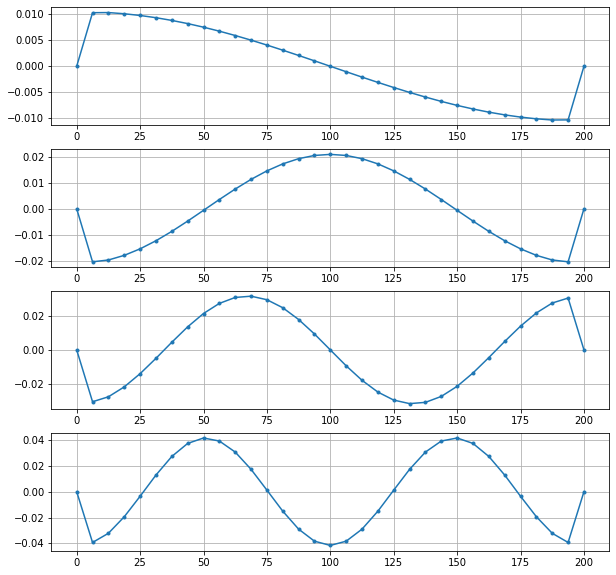

In [27]:
Kontrola.Visualise(mu, Mg, Kg, n=4, direction = 0)

c:\Users\Marko\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


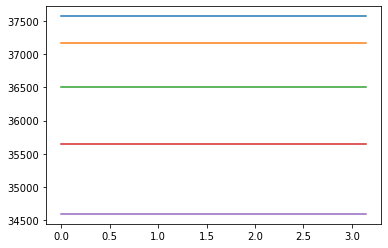

In [29]:
domena = np.linspace(0, np.pi, 100)
r = []
for i in domena:
    r.append(Kontrola.Calc(i,Mg, Kg)[0][:5])

plt.plot(domena, np.sqrt(r))

### Old code

In [9]:
 def Plot(self, mu:float, Mg, Kg):
        """
        Plots shape of element
        """
        f, points = self.Calc(mu, Mg, Kg)

        domain = np.linspace(0, self.L, self.n + 1)


        values = list(points[0,:])
        resonator = values.pop()
        values.append(values[0]*np.e**(1j*mu))
        
        #Apply boundary conditions
        for DOF in self.Restricted_DOF:
            values.insert(0,0)

        plt.plot(domain, values[::2])
        plt.plot(self.L/2, values[int(self.n/2)] + resonator,marker="s", markersize=10, markeredgecolor="blue", markerfacecolor="blue")

        return points

    
    def Calc_nonred(self, Mg, Kg):
        """
        Calculates Dynamics matrix (solves EVP problem)

        :param mu: mu
        :param Mg: Global Mass Matrix
        :param Kg: GLobal Stiffness Matrix
        """ 

        Kg = self.Generate_Kg()
        Mg = self.Generate_Mg()
        

        for DOF in self.Restricted_DOF:
            for i in [0,1]:
                Mg = np.delete(Mg, DOF, axis=i)
                Kg = np.delete(Kg, DOF, axis=i)

        Mginv = lin.inv(Mg)
        #Dg = np.matmul(Mginv,Kg)

        return lin.eig(Kg, Mg)

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 24)

### Source koda iz interneta za osnovni Euler nosilec (4 DOF)

Beam element
Num Elems: 2 	Frequency: 0.645	Error: -81.653% 	Shape: (4, 4)
Num Elems: 3 	Frequency: 0.645	Error: -81.66% 	Shape: (6, 6)
Num Elems: 4 	Frequency: 0.645	Error: -81.662% 	Shape: (8, 8)
Num Elems: 5 	Frequency: 0.645	Error: -81.662% 	Shape: (10, 10)
Exact Freq: 3.516


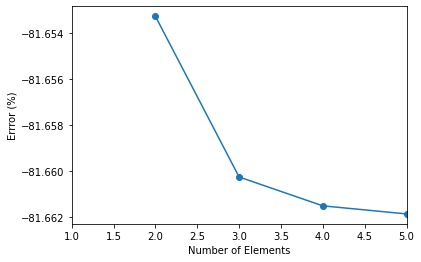

In [ ]:
import numpy as np 
from scipy.linalg import eigh
import math
from matplotlib import pyplot as plt 
import time

def beam(num_elems):
	restrained_dofs = [1, 0]

	l = 200 / num_elems
	Cm = 0.508   # rho.A
	Ck = 27332650   # E.I

	# element mass and stiffness matrices
	m = np.array([[156, 22*l, 54, -13*l],
				  [22*l, 4*l*l, 13*l, -3*l*l],
				  [54, 13*l, 156, -22*l],
				  [-13*l, -3*l*l, -22*l, 4*l*l]]) * Cm * l / 420

	k = np.array([[12, 6*l, -12, 6*l],
				  [6*l, 4*l*l, -6*l, 2*l*l],
				  [-12, -6*l, 12, -6*l],
				  [6*l, 2*l*l, -6*l, 4*l*l]]) * Ck / l**3

	# construct global mass and stiffness matrices
	M = np.zeros((2*num_elems+2,2*num_elems+2))
	K = np.zeros((2*num_elems+2,2*num_elems+2))

	# for each element, change to global coordinates
	for i in range(num_elems):
		M_temp = np.zeros((2*num_elems+2,2*num_elems+2))
		K_temp = np.zeros((2*num_elems+2,2*num_elems+2))
		M_temp[2*i:2*i+4, 2*i:2*i+4] = m
		K_temp[2*i:2*i+4, 2*i:2*i+4] = k
		M += M_temp
		K += K_temp

	# remove the fixed degrees of freedom
	for dof in restrained_dofs:
		for i in [0,1]:
			M = np.delete(M, dof, axis=i)
			K = np.delete(K, dof, axis=i)

	evals, evecs = eigh(K,M)
	frequencies = np.sqrt(evals)
	return M, K, frequencies, evecs

# beam element
print ('Beam element')
# exact_frequency = math.pi**2   #  simply supported
exact_frequency = 1.875104**2  #  cantilever beam
# exact_frequency = 3.926602**2  #  built in - pinned beam
#exact_frequency = 4.730041**2  #  fixed-fixed

errors = []
for i in range(2,6):     # number of elements
    M, K, frequencies, evecs = beam(i)
    error = (frequencies[0] - exact_frequency) / exact_frequency * 100.0
    errors.append( (i, error) )
    print ('Num Elems: {} \tFrequency: {}\tError: {}% \tShape: {}'.format( i, round(frequencies[0],3), round(error, 3), K.shape))

print('Exact Freq:', round(exact_frequency, 3))

element  = np.array([x[0] for x in errors])
error   = np.array([x[1] for x in errors])


# plot the result
plt.plot(element, error, 'o-')
plt.xlim(1, element[-1])
plt.xlabel('Number of Elements')
plt.ylabel('Errror (%)')
plt.show()